In [96]:
from dotenv import dotenv_values
import os
import requests
import json
import pandas as pd
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word

import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
from dash import html
import dash_html_components as html
from dash.dependencies import Input, Output

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [6]:
config = dotenv_values("C:\\Users\\justi\\OneDrive\\Documents\\MSc Data Analytics\\Semester 1 - CA 2\\.env")

In [9]:
# Set the search query and the number of tweets to retrieve
query = "potatoes"
count = 100

# Set the API endpoint and the Bearer Token for authenticating the request
endpoint = "https://api.twitter.com/2/tweets/search/recent"
bearer_token = config["BEARER_TOKEN"]

# Set the headers for the request
headers = {
    "Authorization": f"Bearer {bearer_token}",
    "User-Agent": "v2RecentSearchPython",
}

# Set the parameters for the request
params = {
    "query": query,
    "max_results": count,
    "expansions": "author_id,referenced_tweets.id",
    "user.fields": "username",
    "tweet.fields": "public_metrics"
}

# Make the request to the API endpoint
response = requests.get(endpoint, headers=headers, params=params)

tweet_dicts = []

# Check the status code of the response
if response.status_code == 200:
    # If the request was successful, parse the JSON response
    data = response.json()

    # Print the tweets
    for tweet in data["data"]:
        tweet_dict = {
            "id": tweet["id"],
            "like_count": tweet["public_metrics"]["like_count"],
            "quote_count": tweet["public_metrics"]["quote_count"],
            "retweet_count": tweet["public_metrics"]["retweet_count"],
            "text": tweet["text"]
        }
        tweet_dicts.append(tweet_dict)
else:
    # If the request was not successful, print the error message
    print(f"Error: {response.status_code}")

In [12]:
tweets_df = pd.DataFrame(tweet_dicts)

In [13]:
tweets_df.head()

,id,like_count,quote_count,retweet_count,text
0,1608843281768808448,0,0,0,Today's lunch specials at the Catawba Deli inc...
1,1608843248776413185,0,0,3135,RT @Cobratate: I got beans greens potatoes tom...
2,1608843235346243589,0,0,29,RT @30vocamusic: becoming potatoes - neru http...
3,1608843229591633920,0,0,0,"Now greens, beans, potatoes, and everything el..."
4,1608843130538962945,0,0,503,RT @catturd2: Been cooking this all day - my f...


In [15]:
# I've save the dataframe as a csv file so I can reproduce my analysis with the same tweets
#tweets_df.to_csv('tweets_df.csv')

In [ ]:
# Before doing the sentiment analysis, I need to process the text to make a clearer signal

In [97]:
tweets_df = pd.read_csv('tweets_df.csv')

In [98]:
# First of all I'll make all words lower case

tweets_df['text'] = tweets_df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
tweets_df['text'].head()

0    today's lunch specials at the catawba deli inc...
1    rt @cobratate: i got beans greens potatoes tom...
2    rt @30vocamusic: becoming potatoes - neru http...
3    now greens, beans, potatoes, and everything el...
4    rt @catturd2: been cooking this all day - my f...
Name: text, dtype: object

In [99]:
# Next I'll remove twitter handles seen as these have nothing to do with the sentiment of the tweet

tweets_df['text'] = tweets_df['text'].str.replace('@\w+', '')
tweets_df.head()

C:\Users\justi\AppData\Local\Temp\ipykernel_7944\2817344102.py:3: FutureWarning:

The default value of regex will change from True to False in a future version.



,Unnamed: 0,id,like_count,quote_count,retweet_count,text
0,0,1608843281768808448,0,0,0,today's lunch specials at the catawba deli inc...
1,1,1608843248776413185,0,0,3135,rt : i got beans greens potatoes tomatoes lamb...
2,2,1608843235346243589,0,0,29,rt : becoming potatoes - neru https://t.co/3gy...
3,3,1608843229591633920,0,0,0,"now greens, beans, potatoes, and everything el..."
4,4,1608843130538962945,0,0,503,rt : been cooking this all day - my famous cat...


In [100]:
# Next I'll remove punctuation

tweets_df['text'] = tweets_df['text'].str.replace('[^\w\s]', '')
tweets_df['text'].head()

C:\Users\justi\AppData\Local\Temp\ipykernel_7944\2661965721.py:3: FutureWarning:

The default value of regex will change from True to False in a future version.



0    todays lunch specials at the catawba deli incl...
1    rt  i got beans greens potatoes tomatoes lambs...
2       rt  becoming potatoes  neru httpstco3gyi1s8lt5
3    now greens beans potatoes and everything else ...
4    rt  been cooking this all day  my famous cattl...
Name: text, dtype: object

In [101]:
# Next I'll remove stop words, ie commonly occurring words

stop = stopwords.words('english')

tweets_df['text'] = tweets_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
tweets_df['text'].head()

0    todays lunch specials catawba deli include 2 c...
1    rt got beans greens potatoes tomatoes lambs ra...
2         rt becoming potatoes neru httpstco3gyi1s8lt5
3    greens beans potatoes everything else saybut s...
4    rt cooking day famous cattle trail stew basica...
Name: text, dtype: object

In [102]:
# I'll next look at frequently occurring words, some of which might not be relevant for sentiment analysis
# I'll remove rt, ie retweet because it's not relevant for sentiment

freq = pd.Series(' '.join(tweets_df['text']).split()).value_counts()[:10]
print(freq)

tweets_df['text'] = tweets_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq.index[1]))

tweets_df['text'].head()

potatoes    95
rt          43
name        22
like        21
tomatoes    20
sweet       20
day         20
chicken     17
think       13
dogs        12
dtype: int64


0    todays lunch specials catawba deli include 2 c...
1    got beans greens potatoes tomatoes lambs rams ...
2            becoming potatoes neru httpstco3gyi1s8lt5
3    greens beans potatoes everything else saybut s...
4    cooking day famous cattle trail stew basically...
Name: text, dtype: object

In [103]:
# Next I'll consider infrequent words
# I only have a 100 tweets so I won't remove infrequent words just because they're infrequent
# However, I will remove the words which start with https since these will have nothing to do with sentiment

freq = pd.Series(' '.join(tweets_df['text']).split()).value_counts()[-10:]
print(freq)

words_remove = list(freq.index[freq.index.str.startswith('https')])

tweets_df['text'] = tweets_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in words_remove))

tweets_df['text'].head()

match                 1
perfect               1
say                   1
mind                  1
boggles               1
httpstco7ok9poa3qs    1
httpstcouuafagzcyg    1
httpstcolfbvjgquin    1
love                  1
individually          1
dtype: int64


0    todays lunch specials catawba deli include 2 c...
1    got beans greens potatoes tomatoes lambs rams ...
2            becoming potatoes neru httpstco3gyi1s8lt5
3    greens beans potatoes everything else saybut s...
4    cooking day famous cattle trail stew basically...
Name: text, dtype: object

In [104]:
# Next I'll correct spelling mistakes

tweets_df['text'] = tweets_df['text'].apply(lambda x: str(TextBlob(x).correct()))

tweets_df['text'].head()

0    today lunch special catawba delhi include 2 ch...
1    got beans green potatoes potatoes lambs rams h...
2            becoming potatoes peru httpstco3gyi1s8lt5
3    green beans potatoes everything else salut soo...
4    cooking day famous cattle trail stew basically...
Name: text, dtype: object

In [105]:
# Finally I'll lematize the words

tweets_df['text'] = tweets_df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

tweets_df['text'].head()

0    today lunch special catawba delhi include 2 ch...
1    got bean green potato potato lamb ram hog dog ...
2              becoming potato peru httpstco3gyi1s8lt5
3    green bean potato everything else salut soon m...
4    cooking day famous cattle trail stew basically...
Name: text, dtype: object

In [106]:
# Now I'll produce the sentiment analysis

tweets_df['sentiment'] = tweets_df['text'].apply(lambda x: TextBlob(x).sentiment[0])

tweets_df[['text', 'sentiment']].head()

,text,sentiment
0,today lunch special catawba delhi include 2 ch...,-0.060714
1,got bean green potato potato lamb ram hog dog ...,-0.400000
2,becoming potato peru httpstco3gyi1s8lt5,0.450000
3,green bean potato everything else salut soon m...,-0.256250
4,cooking day famous cattle trail stew basically...,0.500000


In [107]:
tweets_df['sentiment'].mean()

0.08580643939393935

In [108]:
# Let's try some classification

tweets_df['Class'] = tweets_df.sentiment.apply(lambda x: 'Positive' if x >= 0 else 'Negative')
    


In [109]:
tweets_df = tweets_df[['text', 'Class']]
tweets_df.head()

,text,Class
0,today lunch special catawba delhi include 2 ch...,Negative
1,got bean green potato potato lamb ram hog dog ...,Negative
2,becoming potato peru httpstco3gyi1s8lt5,Positive
3,green bean potato everything else salut soon m...,Negative
4,cooking day famous cattle trail stew basically...,Positive


In [110]:
y = tweets_df['Class']

# Create a CountVectorizer object to transform the text strings into numerical features
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(tweets_df['text'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 593), (20, 593), (80,), (20,))

In [111]:

# Create a LogisticRegression model
log_reg = LogisticRegression()

# Fit the model to the training data
log_reg.fit(X_train, y_train)

LogisticRegression()

In [112]:
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

In [114]:
y_test_pred.shape

(20,)

In [115]:
conf_mat = confusion_matrix(y_test, y_test_pred)

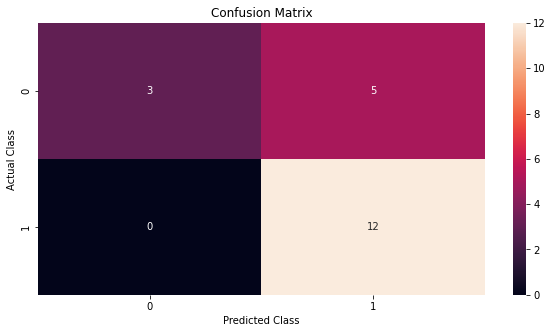

In [118]:
plt.subplots(figsize = (10, 5))

sns.heatmap(conf_mat, annot = True, fmt = 'd')

# Add a title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

# Show the plot
#plt.show()

plt.savefig('C:\\Users\\justi\\OneDrive\\Documents\\MSc Data Analytics\\Semester 1 - CA 2\\Plots\\figure5.png')

In [1]:
# Starting Dashboard

In [39]:
df = pd.read_csv('df_merged.csv')

In [40]:
df.head()

,Unnamed: 0,crops,strucpro,geo,Year,Yields,irrigation,PC0,PC1-24,PC25-49,...,NAP,PRACT,Precipitation,Temperature,BAL_UAA_N,INP_UAA_N,OUT_UAA_N,BAL_UAA_P,INP_UAA_P,OUT_UAA_P
0,0,R1000,YI_HU_EU,AT,2010,30.57,medium,very low,very low,very low,...,very low,low,1158.11,6.53,32.1,105.3,73.2,0.9,14.0,13.1
1,1,R1000,YI_HU_EU,BE,2010,30.57,low,very low,very low,very low,...,very low,medium,910.47,9.36,142.0,313.7,171.8,5.0,32.0,27.0
2,2,R1000,YI_HU_EU,BG,2010,18.19,high,very low,very low,very low,...,very low,medium,787.21,11.79,14.2,70.3,56.1,-5.0,6.0,12.0
3,3,R1000,YI_HU_EU,CY,2010,19.27,high,high,very low,very low,...,very low,medium,418.97,20.35,191.4,240.9,49.5,31.0,43.0,12.0
4,4,R1000,YI_HU_EU,CZ,2010,24.56,medium,very low,very low,very low,...,very low,very low,860.45,7.43,67.1,145.2,78.1,-2.1,11.1,13.1


In [41]:
numeric_cols = df.select_dtypes(include = ['int', 'float'])

other_cols = df[['crops', 'geo']]

df_num_long = pd.concat([numeric_cols, other_cols], axis = 1).drop(columns = 'Unnamed: 0') \
                                                             .melt(id_vars = ['crops', 'geo', 'Year'])

df_num_long.head()

,crops,geo,Year,variable,value
0,R1000,AT,2010,Yields,30.57
1,R1000,BE,2010,Yields,30.57
2,R1000,BG,2010,Yields,18.19
3,R1000,CY,2010,Yields,19.27
4,R1000,CZ,2010,Yields,24.56


In [42]:
df_cat_long = df.select_dtypes(include = ['int', 'object']).drop(columns = ['Unnamed: 0', 'strucpro']) \
                                                           .melt(id_vars = ['crops', 'geo', 'Year'])
        

In [43]:
df_cat_long.head()

,crops,geo,Year,variable,value
0,R1000,AT,2010,irrigation,medium
1,R1000,BE,2010,irrigation,low
2,R1000,BG,2010,irrigation,high
3,R1000,CY,2010,irrigation,high
4,R1000,CZ,2010,irrigation,medium


In [45]:
df_hot = pd.read_csv('df_merged_hot.csv')

In [47]:
df_hot['Yields_lag'] = df_hot.groupby('geo').Yields.shift(periods = 1)
df_hot_geo = df_hot.geo
df_hot.drop(columns = ['Unnamed: 0', 'crops', 'strucpro', 'geo', 'Year'], inplace = True)
df_hot.dropna(inplace = True)

In [48]:
df_hot.head()

,Yields,Precipitation,Temperature,BAL_UAA_N,INP_UAA_N,OUT_UAA_N,BAL_UAA_P,INP_UAA_P,OUT_UAA_P,irrigation_high,...,FULL_medium,FULL_very high,FULL_very low,NAP_low,NAP_very low,PRACT_high,PRACT_low,PRACT_medium,PRACT_very low,Yields_lag
26,0.840492,0.604014,-0.693645,-0.541567,-0.379177,-0.114370,-0.267367,-0.109592,0.164759,0,...,0,0,0,0,1,0,1,0,0,0.309926
27,1.949107,-0.027835,0.233101,2.166744,2.503788,2.047777,0.458771,2.162410,1.902453,0,...,0,0,0,0,1,0,0,1,0,0.309926
28,-1.375706,-1.118330,0.145512,-1.135032,-1.216264,-0.935571,-1.171335,-1.720126,-0.467131,1,...,0,0,0,0,1,0,0,1,0,-0.967975
29,-0.276381,-1.188684,2.315453,3.562392,1.446097,-1.213635,4.459939,3.600386,-0.625103,1,...,0,0,1,0,1,0,0,1,0,-0.856494
30,0.297539,-0.877392,-0.411101,0.564893,0.330988,-0.031211,-0.771218,-0.713542,0.054178,0,...,0,1,0,0,1,0,0,0,1,-0.310445


In [83]:
X = df_hot.drop(columns = 'Yields')

pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)

X_pca_df = df_hot[['Yields']]
X_pca_df['X_pca'] = X_pca

#X_pca_df = pd.DataFrame(X_pca, columns = ['x', 'y'])

C:\Users\justi\AppData\Local\Temp\ipykernel_7944\3553023536.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [61]:
X_pca_df.head()

,Yields,X_pca
26,0.840492,-0.423721
27,1.949107,4.606657
28,-1.375706,-2.902940
29,-0.276381,2.764496
30,0.297539,0.230175


In [53]:
df_hot.shape

(312, 79)

In [55]:
y = df_hot['Yields']
X = df_hot.drop(columns = 'Yields')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [73]:
X_pca_df.head()

,Yields,X_pca
26,0.840492,-0.423721
27,1.949107,4.606657
28,-1.375706,-2.902940
29,-0.276381,2.764496
30,0.297539,0.230175


In [94]:
app = JupyterDash(__name__)

variables_num = df_num_long.variable.unique()
options_num = [{'label': value, 'value': value} for value in variables_num]

variables_cat = df_cat_long.variable.unique()
options_cat = [{'label': value, 'value': value} for value in variables_cat]

radio_options = [{'label': 'Scatter Plot', 'value': 'scatter'}, {'label': 'Time Series Plot', 'value': 'time'}]

radio_options_intercept = [{'label': 'True', 'value': True}, {'label': 'False', 'value': False}]

# Create the first tab
tab1 = dcc.Tab(label='Numerical Var. Graphs', value='', children=[
    html.H1(children=''),
    html.P('Select Variable to plot in dropdown menu. Radio Button can switch between scatter and line plot.'),
    html.Div([
        dcc.Dropdown(id='var_num-dropdown', value = variables_num[0], options=options_num),
        dcc.RadioItems(id = 'graph_type', options = radio_options, value = 'scatter')
    ]),
    dcc.Graph(id='graph-1')
])


# Create the second tab
tab2 = dcc.Tab(label='Categorical Var. Graphs', value='', children=[
    html.H1(children=''),
    html.P('Select Variable to plot in dropdown menu.'),
    html.Div([
        dcc.Dropdown(id='var_cat-dropdown', value = variables_cat[0], options=options_cat)
    ]),
    dcc.Graph(id='graph-2')
])


# Create the third tab
tab3 = dcc.Tab(label='Clustering', value='', children=[
    html.H1(children=''),
    html.P('Input number of Clusters. Note that the number of clusters cannot be 0'),
    html.Div([
        dcc.Input(id='clusters', type = 'number', value = 1)
    ]),
    dcc.Graph(id='graph-3')
])

# Create the third tab
tab4 = dcc.Tab(label='Ridge Regression', value='', children=[
    html.H1(children=''),
    html.P('Select Alpha Slope Penalty Parameter:'),
    html.Div([
        dcc.Input(id='alpha', type = 'number', value = 1),
        dcc.RadioItems(id = 'intercept', options = radio_options_intercept, value = True)
        
    ]),
    dcc.Graph(id='graph-4')
])


# Set up the layout of the app
app.layout = html.Div([
    html.H1('Potato Crop Yields Dashboard'),
    dcc.Tabs(id='tabs', value='tab-1', children=[tab1, tab2, tab3, tab4])
])




@app.callback(
    Output('graph-1', 'figure'),
    [Input('var_num-dropdown', 'value'), Input('graph_type', 'value')],
    )

def update_graph1(variable_num, graph_type):
    
    filtered_df = df_num_long[df_num_long.variable == variable_num]
    
    if graph_type == 'scatter':
        
        fig = px.scatter(filtered_df, x = 'Year', y = 'value', color = 'geo', title = variable_num)
        return fig
    
    else:
        fig = px.line(filtered_df, x = 'Year', y = 'value', color = 'geo', title = variable_num)
        return fig


@app.callback(
    Output('graph-2', 'figure'),
    Input('var_cat-dropdown', 'value'))

def update_graph2(variable_cat):
    
    filtered_df = df_cat_long[df_cat_long.variable == variable_cat]
    
    fig = px.bar(filtered_df, x = 'value', title = variable_cat)
    return fig


@app.callback(
    Output('graph-3', 'figure'),
    [Input('clusters', 'value')]
    )

def update_graph3(clusters):
    
    X = df_hot.drop(columns = 'Yields')

    pca = PCA(n_components=1)
    X_pca = pca.fit_transform(X)

    X_pca_df = df_hot[['Yields']]
    X_pca_df['X_pca'] = X_pca
    
    kmeans = KMeans(n_clusters = clusters)
    clusters_fit = kmeans.fit_predict(X_pca_df)
    
    X_pca_df['cluster'] = clusters_fit
    X_pca_df['geo'] = df_hot_geo
    
    #fig = px.scatter(X_pca_df, x='x', y='y', color='cluster', title= f'K Means with {clusters} Clusters')
    fig = px.scatter(X_pca_df, x = 'X_pca', y = 'Yields', color = 'cluster')
    
    # Highlight the points with geo == 'IE' by coloring the edges green
    #ie_mask = X_pca_df['geo'] == 'IE'
    #fig.add_scatter(x = X_pca_df.X_pca[ie_mask], y = X_pca_df.Yields[ie_mask], marker = dict(color = 'green'), name = 'Ireland')
    
    fig.update_layout(title = f'K Means with {clusters} Clusters', xaxis_title = 'X_pca', yaxis_title = 'Yields')
    
    return fig

@app.callback(
    Output('graph-4', 'figure'),
    [Input('alpha', 'value'), Input('intercept', 'value')]
    )
    
    
def update_graph4(alpha, intercept):
    
    ridge_model = Ridge(alpha = alpha, fit_intercept = intercept)
    
    ridge_model.fit(X_train, y_train)
    y_train_pred = ridge_model.predict(X_train)
    y_test_pred = ridge_model.predict(X_test)
    
    df_train = pd.DataFrame({'actual': y_train, 'predicted': y_train_pred})
    df_test = pd.DataFrame({'actual': y_test, 'predicted': y_test_pred})

    df_train['set'] = 'train'
    df_test['set'] = 'test'

    df = pd.concat([df_train, df_test])
    
    train_score = round(ridge_model.score(X_train, y_train), ndigits = 2)
    test_score = round(ridge_model.score(X_test, y_test), ndigits = 2)
    
    fig = px.scatter(df, x="actual", y="predicted", color="set", 
                     title=f"Actual vs Predicted Values. Score Train: {train_score}. Score Test {test_score}")
    fig.add_shape(type="line", x0=df["actual"].min(), y0=df["actual"].min(),
              x1=df["actual"].max(), y1=df["actual"].max(),
              xref="x", yref="y", line=dict(color="green"))
    
    
    
    
    
    return fig

app.run_server(mode = 'inline')

C:\Users\justi\AppData\Local\Temp\ipykernel_7944\236966029.py:112: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\justi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\justi\AppData\Local\Temp\ipykernel_7944\236966029.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\just